### Импортируем библиотеки

In [1]:
# Импорт библиотек для проведения расчетов
import pandas as pd
import numpy as np

In [2]:
# Импорт библиотек для построения и визуализации графов
import networkx as nx
import matplotlib.pyplot as plt

In [172]:
# Библиотека для построения ассоциативных правил: mlxtend
# Документация библиотеки: http://rasbt.github.io/mlxtend/

# Для установки библиотеки требуется раскомментировать строку 5


In [8]:
# Импорт пакетов для выполнения ассоциативных правил
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax

### Загрузка данных

In [9]:
# Указываем путь к файлу
# При работе с google colab существует 2 варианта загрузки файла:
# 1. Через google drive
# 2. Через левое меню: "файлы" -> "загрузить в сессионное хранилище" -> "скопировать файл" (при наведении на файл)
file_path = 'assoc.sas7bdat'

In [10]:
# Загружаем данные из SAS файла
df = pd.read_sas(file_path, encoding='latin-1')
# Пример данных
df.head()

,CUSTOMER,TIME,PRODUCT
0,0.0,0.0,hering
1,0.0,1.0,corned_b
2,0.0,2.0,olives
3,0.0,3.0,ham
4,0.0,4.0,turkey


### Часть 1: Построение моделей ассоциативных правил

In [11]:
# Создадим список транзакций в формате [[1,4,5], [3,5,3], ....]
# Каждый элемент списка - список того, что купил клиент
transactions = df.groupby('CUSTOMER').aggregate({"PRODUCT":list}).values[:, 0]

In [12]:
# Список покупок для первого клиента
transactions[0]

['hering', 'corned_b', 'olives', 'ham', 'turkey', 'bourbon', 'ice_crea']

In [18]:
# Построим модель apriori или fpgrowth (указывается в качестве параметра mode)
def get_frequent_items(transac, model = "apriori"):
    te = TransactionEncoder()
    te_ary = te.fit(transac).transform(transac)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    if model == "apriori":
        return apriori(df, min_support=0.1, use_colnames=True)
    elif model == "fpgrowth":
        return fpgrowth(df, min_support=0.1, use_colnames=True)
    return None

frequent_itemsets_apri = get_frequent_items(transactions, model = "apriori")
frequent_itemsets_fpg = get_frequent_items(transactions, model = "fpgrowth")

In [19]:
frequent_itemsets_apri.head()

,support,itemsets
0,0.313686,(apples)
1,0.304695,(artichok)
2,0.362637,(avocado)
3,0.391608,(baguette)
4,0.402597,(bourbon)


In [20]:
frequent_itemsets_fpg.head()

,support,itemsets
0,0.485514,(hering)
1,0.472527,(olives)
2,0.402597,(bourbon)
3,0.390609,(corned_b)
4,0.312687,(ice_crea)


In [52]:
# Cгенерируем ассоциативные правила с поддержкой выше 0.2 и выведем первые 5
association_rules(frequent_itemsets, metric="support", min_threshold=0.2).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(artichok),(avocado),0.304695,0.362637,0.210789,0.691803,1.907700,0.100295,2.068038
1,(avocado),(artichok),0.362637,0.304695,0.210789,0.581267,1.907700,0.100295,1.660497
2,(artichok),(heineken),0.304695,0.599401,0.251748,0.826230,1.378426,0.069114,2.305336
3,(heineken),(artichok),0.599401,0.304695,0.251748,0.420000,1.378426,0.069114,1.198801
4,(avocado),(baguette),0.362637,0.391608,0.214785,0.592287,1.512446,0.072773,1.492204


1. Как можно заметить, в переменной PRODUCT 20 различных значений.

In [119]:
len(set(df["PRODUCT"]))

20

2. Для начала создадим модели с с minimum confidence 30%.

In [120]:
apr = association_rules(frequent_itemsets_apri, metric="confidence", min_threshold=0.3)
fpg = association_rules(frequent_itemsets_fpg, metric="confidence", min_threshold=0.3)

In [121]:
apr.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(apples),(avocado),0.313686,0.362637,0.138861,0.442675,1.220710,0.025107,1.143611
1,(avocado),(apples),0.362637,0.313686,0.138861,0.382920,1.220710,0.025107,1.112196
2,(apples),(baguette),0.313686,0.391608,0.146853,0.468153,1.195462,0.024011,1.143922
3,(baguette),(apples),0.391608,0.313686,0.146853,0.375000,1.195462,0.024011,1.098102
4,(apples),(corned_b),0.313686,0.390609,0.150849,0.480892,1.231132,0.028320,1.173918


2. После этого найдем правило, содержащее "chicken" на первои месте и с наибольшим confidence и support. 

In [160]:
confmax = 0
supmax = 0
k = 0
for i in range(len(apr)):
    x = list(apr["antecedents"][i])
    if (x[0] == "chicken" and apr["confidence"][i] > confmax) or (x[0] == "chicken" and apr["confidence"][i] == confmax and apr["support"][i] > supmax):
        confmax = apr["confidence"][i]
        supmax = apr["support"][i]
        k = i
print(apr.iloc[[k]])

   antecedents consequents  antecedent support  consequent support   support  \
82   (chicken)  (heineken)            0.314685            0.599401  0.200799   

    confidence      lift  leverage  conviction  
82    0.638095  1.064556  0.012177    1.106919  


In [23]:
fpg.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(hering),(heineken),0.485514,0.599401,0.287712,0.592593,0.988642,-0.003305,0.983289
1,(heineken),(hering),0.599401,0.485514,0.287712,0.480000,0.988642,-0.003305,0.989395
2,(hering),(cracker),0.485514,0.487512,0.200799,0.413580,0.848348,-0.035895,0.873926
3,(cracker),(hering),0.487512,0.485514,0.200799,0.411885,0.848348,-0.035895,0.874805
4,"(hering, heineken)",(cracker),0.287712,0.487512,0.162837,0.565972,1.160939,0.022574,1.180771


In [167]:
confmax = 0
supmax = 0
k = 0
for i in range(len(fpg)):
    x = list(fpg["antecedents"][i])
    if (x[0] == "chicken" and fpg["confidence"][i] > confmax) or (x[0] == "chicken" and fpg["confidence"][i] == confmax and fpg["support"][i] > supmax):
        confmax = fpg["confidence"][i]
        supmax = fpg["support"][i]
        k = i
print(fpg.iloc[[k]])

    antecedents consequents  antecedent support  consequent support   support  \
976   (chicken)  (heineken)            0.314685            0.599401  0.200799   

     confidence      lift  leverage  conviction  
976    0.638095  1.064556  0.012177    1.106919  


2. Как можно заметить, обе модели показали одинаковое правило chicken -> heineken. Это означает, что среди всех людей купивших курицу, самой вероятной следующей покупкой будет heineken. 

3. Поддержка этого правила равна 0.200799. Это означает, что среди всех покупок, последовательность chicken -> heineken оказалась в 20% всех чеков. 

### Часть 2: Анализ графов связности

In [168]:
# Построим направленный мультиграф
# Граф построен на направленных связях последовательных покупок
G=nx.MultiDiGraph()
for t in transactions:
    for i in range(len(t) - 1):
        G.add_edge(t[i],t[i+1])

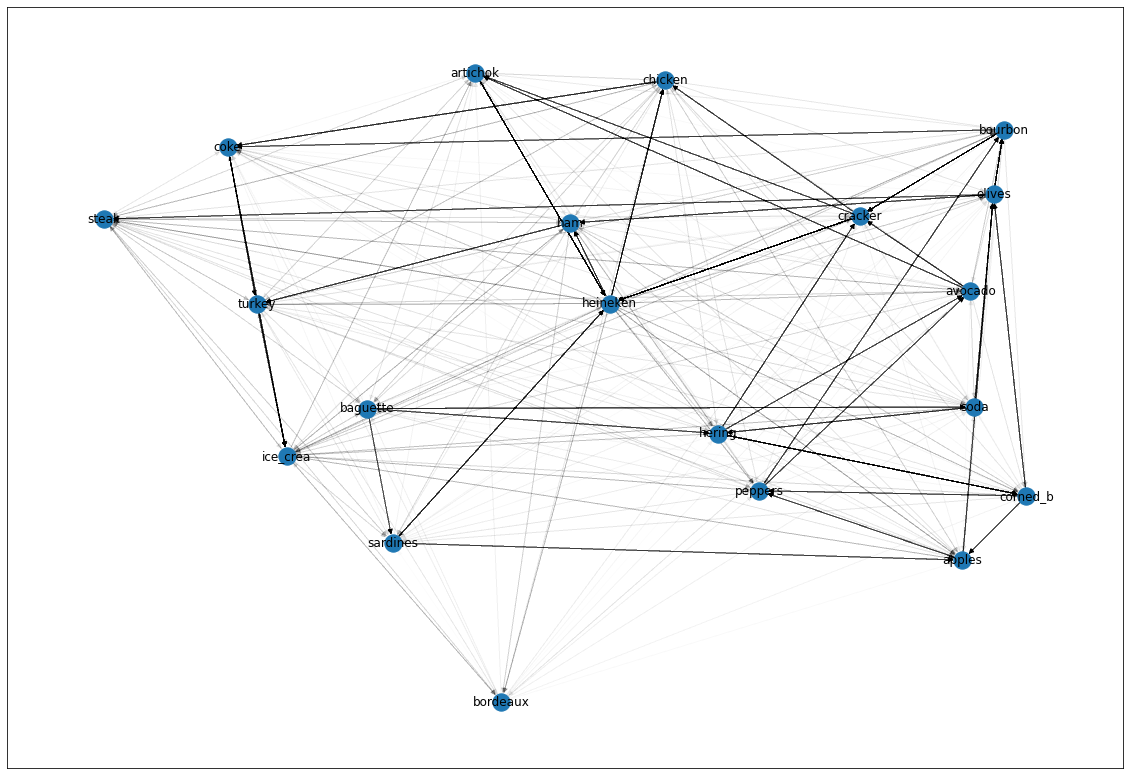

In [169]:
# Визуализируем граф
plt.figure(figsize=(20, 14))
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos)
edges = nx.draw_networkx_edges(G, pos, alpha=0.01)
labels = nx.draw_networkx_labels(G, pos)

In [14]:
# Также, можно рассчитать метрики центральности
# Все доступные метрики: https://networkx.org/documentation/stable/reference/algorithms/centrality.html

# Пример расчета меры closeness
nx.closeness_centrality(G)

{'apples': 1.0,
 'artichok': 1.0,
 'avocado': 1.0,
 'baguette': 0.8636363636363636,
 'bordeaux': 0.6129032258064516,
 'bourbon': 1.0,
 'chicken': 1.0,
 'coke': 1.0,
 'corned_b': 1.0,
 'cracker': 0.9047619047619048,
 'ham': 1.0,
 'heineken': 0.8636363636363636,
 'hering': 0.9047619047619048,
 'ice_crea': 1.0,
 'olives': 0.95,
 'peppers': 0.95,
 'sardines': 0.95,
 'soda': 1.0,
 'steak': 1.0,
 'turkey': 0.9047619047619048}

**Вопрос части 2**: посмотрите на график и ответьте на вопрос после какого продукта обычно приобретается soda (вариант I) или sardines (вариант II)

2. Как можно заметить на графе, самой явной стрелкой к sardines является стрелка от baguette. Попробуем подтвердить этот факт числами.

In [180]:
Nod = ['hering', 'corned_b', 'olives', 'ham', 'turkey', 'bourbon', 'ice_crea', 'baguette', 'soda', 'cracker', 'heineken', 'avocado', 'artichok', 'coke', 'peppers', 'apples', 'steak', 'chicken', 'bordeaux']
for i in Nod:
    print(i, "->", "sardines", G.number_of_edges(i, "sardines"))

hering -> sardines 2
corned_b -> sardines 4
olives -> sardines 0
ham -> sardines 10
turkey -> sardines 5
bourbon -> sardines 4
ice_crea -> sardines 11
baguette -> sardines 90
soda -> sardines 4
cracker -> sardines 2
heineken -> sardines 20
avocado -> sardines 2
artichok -> sardines 1
coke -> sardines 2
peppers -> sardines 2
apples -> sardines 4
steak -> sardines 13
chicken -> sardines 3
bordeaux -> sardines 1


2. Как можно заметить выше, чаще всего sardines покупают после baguette.